<a href="https://colab.research.google.com/github/mohannn-sys/ColposcopyImageSegmentation/blob/main/RandomForestClassifierForColposcopyImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
import glob

# Preparing Dataset
Out of 42 processed images

No. of training images = 37

No. of testing images = 5

In [ ]:
# Define the paths to your image and mask folders
image_folder = '/content/drive/MyDrive/TrainingData/ProcessedImages'
mask_folder = '/content/drive/MyDrive/TrainingData/Mask'

# Get sorted lists of image and mask files
image_files = sorted(glob.glob(os.path.join(image_folder, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(mask_folder, '*.png')))

train_image_files = image_files[:37]
train_mask_files = mask_files[:37]

test_image_files = image_files[37:]
test_mask_files = mask_files[37:]

print(len(train_image_files))
print(len(train_mask_files))
print(len(test_image_files))
print(len(test_mask_files))

37
37
5
5


In [ ]:
# Prepare training data
X_train = []
y_train = []

for image_file, mask_file in zip(train_image_files, train_mask_files):
    img = cv2.imread(image_file)   # Load image

    img_array = img / 255.0   # Normalize pixel values to [0, 1]
    img_array = cv2.resize(img_array, (512, 512))   #resize


    # Load mask
    mask = cv2.imread(mask_file, 0)  # Load mask as grayscale
    mask_array = mask / 255.0  # Normalize pixel values to [0, 1]
    mask_array = mask_array.astype(np.float32)
    # Resize mask to (256, 256, 1)
    mask_array = cv2.resize(mask_array, (512, 512))
    mask_array = np.expand_dims(mask_array, axis=-1)  # Add a channel dimension
    # Apply threshold to create binary mask
    threshold = 0.5  # Adjust threshold if needed
    mask_array = np.where(mask_array > threshold, 1, 0)  # Set pixels above threshold to 1

    flattened_image = img_array.reshape(-1, 3)
    binary_mask = mask_array.ravel()


    X_train.append(flattened_image)
    y_train.append(binary_mask)

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train, axis = 0)

print(X_train.shape, y_train.shape)

(9699328, 3) (9699328,)


In [ ]:
print(np.max(X_train), np.min(X_train))
print(np.unique(y_train, return_counts=True))

1.0 0.0
(array([0, 1]), array([7778169, 1921159]))


In [ ]:
# Load and preprocess images and masks
X_test = []
y_test = []

for image_file, mask_file in zip(test_image_files, test_mask_files):
    # Load image
    img = cv2.imread(image_file)
    # Normalize pixel values to [0, 1]
    img_array = img / 255.0
    img_array = cv2.resize(img_array, (512, 512))  # Resize to (256, 256, 3)


    # Load mask
    mask = cv2.imread(mask_file, 0)  # Load as grayscale
    mask_array = mask / 255.0  # Normalize pixel values to [0, 1]
    mask_array = mask_array.astype(np.float32)
    # Resize mask to (256, 256, 1)
    mask_array = cv2.resize(mask_array, (512, 512))
    mask_array = np.expand_dims(mask_array, axis=-1)  # Add a channel dimension
    # Apply threshold to create binary mask
    threshold = 0.5  # Adjust threshold if needed
    mask_array = np.where(mask_array > threshold, 1, 0)  # Set pixels above threshold to 1

    flattened_image = img_array.reshape(-1, 3)
    binary_mask = mask_array.ravel()


    X_test.append(flattened_image)
    y_test.append(binary_mask)

X_test = np.vstack(X_test)
y_test = np.concatenate(y_test, axis = 0)

print(X_test.shape, y_test.shape)

(1310720, 3) (1310720,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define your RandomForestClassifier
clf = RandomForestClassifier()

# Define the hyperparameters you want to tune
param_grid = {
    'max_depth': [20],
    'n_estimators': [20],
    'min_samples_leaf': [5],
    'min_samples_split': [10]
}

# Define GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [20]},
             scoring='accuracy')

In [ ]:
# Print cross-validation accuracy for each parameter combination
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print("Cross-validation Accuracy:", mean_score, "Parameters:", params)


# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_clf = grid_search.best_estimator_

# Predict on validation data
y_pred = best_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Cross-validation Accuracy: 0.8773612960935046 Parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}
Accuracy: 0.8195945739746093


In [ ]:
cv_results

{'mean_fit_time': array([667.44144034]),
 'std_fit_time': array([106.73338556]),
 'mean_score_time': array([11.16777539]),
 'std_score_time': array([1.68065686]),
 'param_max_depth': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 20,
   'min_samples_leaf': 5,
   'min_samples_split': 10,
   'n_estimators': 20}],
 'split0_test_score': array([0.87802405]),
 'split1_test_score': array([0.8928493]),
 'split2_test_score': array([0.87589452]),
 'split3_test_score': array([0.85971086]),
 'split4_test_score': array([0.88032775]),
 

In [ ]:
pred_mask = best_clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_mask)
print(conf_matrix)

# Calculate and print the classification report
print(classification_report(y_test, pred_mask))

# Calculate and print class-wise IoU
iou = (conf_matrix.diagonal() / (conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - conf_matrix.diagonal()))
print("Class-wise IoU:", iou)

[[869764  38365]
 [198096 204495]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88    908129
           1       0.84      0.51      0.63    402591

    accuracy                           0.82   1310720
   macro avg       0.83      0.73      0.76   1310720
weighted avg       0.82      0.82      0.80   1310720

Class-wise IoU: [0.78624511 0.46375375]


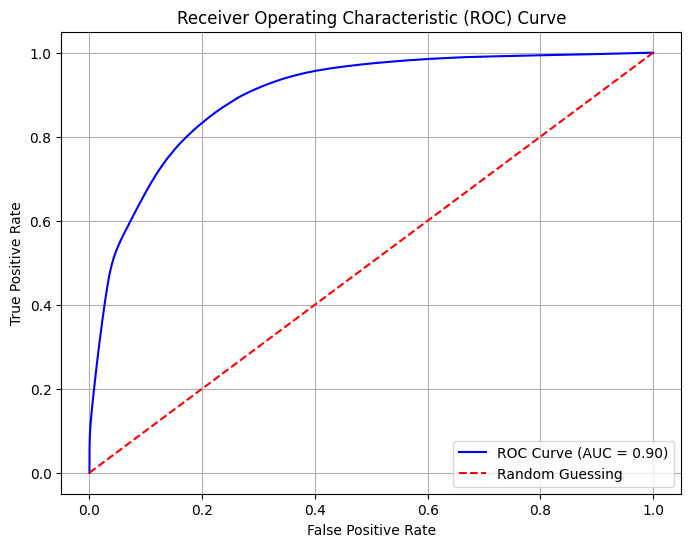

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Get the best estimator from grid search
best_model = grid_search.best_estimator_

# Make predictions on testing data
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_proba)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Initialize the subplot axes
n_images = len(test_image_files)
fig, ax = plt.subplots(n_images, 3, figsize=(12, 4 * n_images))

for i in range(n_images):
    image_file = test_image_files[i]
    mask_file = test_mask_files[i]

    # Load image
    img = cv2.imread(image_file)
    # Normalize pixel values to [0, 1]
    img_array = img / 255.0
    img_array = cv2.resize(img_array, (512, 512))  # Resize to (256, 256, 3)


    # Load mask
    mask = cv2.imread(mask_file, 0)  # Load as grayscale
    mask_array = mask / 255.0  # Normalize pixel values to [0, 1]
    mask_array = mask_array.astype(np.float32)
    # Resize mask to (256, 256, 1)
    mask_array = cv2.resize(mask_array, (512, 512))
    mask_array = np.expand_dims(mask_array, axis=-1)  # Add a channel dimension
    # Apply threshold to create binary mask
    threshold = 0.5  # Adjust threshold if needed
    mask_array = np.where(mask_array > threshold, 1, 0)  # Set pixels above threshold to 1

    flattened_image = img_array.reshape(-1, 3)
    binary_mask = mask_array.ravel()

    # Predict the mask
    pred_mask_flattened = best_clf.predict(flattened_image)
    pred_mask = pred_mask_flattened.reshape((512, 512))

    # Display the image, actual mask, and predicted mask
    ax[i, 0].imshow(cv2.cvtColor(cv2.resize(img, (512, 512)), cv2.COLOR_BGR2RGB))
    ax[i, 1].imshow(mask_array, cmap='gray')
    ax[i, 2].imshow(pred_mask, cmap='gray')

    # Set the title of the plot
    ax[i, 0].set_title('Image')
    ax[i, 1].set_title('Actual Mask')
    ax[i, 2].set_title("Predicted Mask")

    # Hide the axis labels
    for j in range(3):
        ax[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()
